In [58]:
import tensorflow as tf
import matplotlib.pyplot as plt
import statsmodels.api as sm ##qq plots
import numpy as np
import xarray as xr
from scipy.special import softmax

import utils.multicrop_dataset as multicrop_dataset
import utils.architecture as architecture

tf.random.set_seed(0)
np.random.seed(0)


options = tf.data.Options()
options.experimental_optimization.noop_elimination = True             # eliminate no-op transformations
tf.compat.v1.data.experimental.OptimizationOptions.map_vectorization = True    # vectorize map transformations
options.experimental_optimization.apply_default_optimizations = True  # apply default graph optimizations
options.experimental_deterministic = True                            # False disable deterministic order
options.threading.max_intra_op_parallelism = 1           # overrides the maximum degree of intra-op parallelism 

In [31]:


def open_nc(file_path):

    try:
        ds = xr.open_dataset(file_path)

    except Exception as e:
        print(f"Error opening file: {e}")
        return 

    else:
        return ds
    
def get_values(variable, file= 'data/msl_t2m_1983_2023.nc',wind = 4, quantile=False):
    #just to save process

    ds = open_nc(file)
    df = ds[variable].values

    if quantile:
        max_o = np.quantile(df,0.99)
        min_o = np.quantile(df,0.1)

        df = np.clip(df, min_o, max_o)

    else:
        min_o = np.min(df)
        max_o = np.max(df)

    norm_imgs = (df - min_o)/(max_o -min_o)

    time, lat, long = norm_imgs.shape

    norm_imgs = norm_imgs.reshape(int(time/wind), wind, lat, long)
    norm_imgs = np.transpose(norm_imgs, (0, 2, 3, 1))

    # np.save(f'data/{variable}',norm_imgs,allow_pickle=False)

    return norm_imgs

DATA_WIND = 4
VARIABLE = 'msl'
data = get_values(VARIABLE,wind=DATA_WIND)

In [32]:
BS = 512
SIZE_CROPS = [50, 32]  
NUM_CROPS= [2,3]

#SCALE FOR CROPPING
MIN_SCALE = [0.7, 0.5]
MAX_SCALE = [1., 0.7]

PROTOTYPES = 30
PROPORTIONS = [] #to not use proportions declare it as empty list

#check
if len(PROPORTIONS):
    PROTOTYPES = len(PROPORTIONS)

MODEL_TAG  = f'{VARIABLE}_{PROTOTYPES}_bs{BS}_wind{DATA_WIND}'

In [33]:
# data = np.load('data/test.npy')
data_tensors = tf.data.Dataset.from_tensor_slices(data) 

# Get multiple data loaders
trainloaders = multicrop_dataset.get_multires_dataset(data_tensors,
    size_crops=SIZE_CROPS,
    num_crops=NUM_CROPS,
    min_scale=MIN_SCALE,
    max_scale=MAX_SCALE,
    options=options)

trainloaders_zipped = tf.data.Dataset.zip(trainloaders)

trainloaders_zipped = (
        trainloaders_zipped
        .batch(BS)
        .prefetch( tf.data.experimental.AUTOTUNE)
    )

2024-08-20 12:10:17.314289: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79195 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0001:00:00.0, compute capability: 8.0
2024-08-20 12:10:20.794077: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9730635200 exceeds 10% of free system memory.
2024-08-20 12:10:25.324045: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9730635200 exceeds 10% of free system memory.


2024-08-20 12:10:27.343022: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9730635200 exceeds 10% of free system memory.


2024-08-20 12:10:29.788615: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9730635200 exceeds 10% of free system memory.
2024-08-20 12:10:35.389529: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9730635200 exceeds 10% of free system memory.
2024-08-20 12:10:51.433184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_40' with dtype float and shape [29950,143,142,4]
	 [[{{node Placeholder/_40}}]]
2024-08-20 12:10:51.433537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [29950,143,142,4]
	 [[{{node Placeholder/_0}}]]


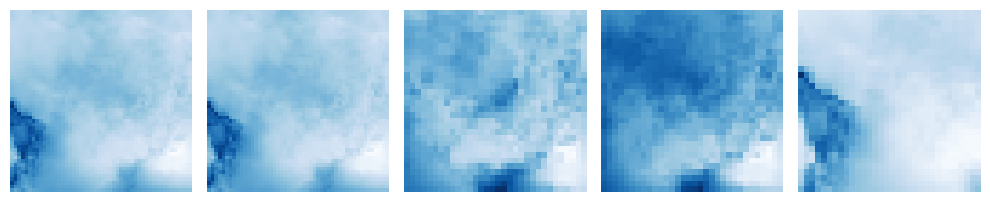

In [34]:
images = [i[3] for i in next(iter(trainloaders_zipped))]

fig, axes = plt.subplots(1, 5, figsize=(10, 7))

for ax, img in zip(axes.ravel(), images):
    
    ax.imshow(img,cmap='Blues')
    ax.axis('off')


for ax in axes.ravel()[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [35]:
feature_backbone = architecture.get_resnet_backbone()
projection_prototype = architecture.get_projection_prototype(prototype_dimension = PROTOTYPES)

In [36]:
decay_steps = 1000

lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)

opt = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn)

In [37]:
# tf.keras.backend.clear_session()

In [38]:
try: 
    feature_backbone.load_weights(f'model_weights/feature2d_{MODEL_TAG}.h5')
    projection_prototype.load_weights(f'model_weights/proj2d_{MODEL_TAG}.h5')

except:
    print(MODEL_TAG,"not found")

msl_30_bs512_wind4 not found


In [39]:
epoch_wise_loss, models_tr = architecture.train_swav(feature_backbone,projection_prototype,
                                        trainloaders_zipped,opt,
                                        crops_for_assign=[0, 1],temperature=0.1,epochs=100,
                                        n_crops = NUM_CROPS, proto_proportions = PROPORTIONS,model_name=MODEL_TAG)

feature_backbone_weights = feature_backbone.get_weights()

  0%|          | 0/59 [00:00<?, ?it/s]

2024-08-20 12:10:55.958193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2024-08-20 12:10:56.050370: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-20 12:11:03.898185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2024-08-20 12:11:57.545622: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x5aab39eab000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-20 12:11:57.545655: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-08-20 12:11:57.564100: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-20 12:11:57.591653: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 59/59 [02:00<00:00,  2.04s/it, loss=2.932] 


epoch: 1 loss: 3.213
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=2.711]


epoch: 2 loss: 2.979
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=2.216]


epoch: 3 loss: 2.776
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.893]


epoch: 4 loss: 2.604
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.87it/s, loss=1.714]


epoch: 5 loss: 2.455
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.615]


epoch: 6 loss: 2.324
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.87it/s, loss=1.479]


epoch: 7 loss: 2.207
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.319]


epoch: 8 loss: 2.106
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.349]


epoch: 9 loss: 2.016
Saving weights


100%|██████████| 59/59 [00:32<00:00,  1.82it/s, loss=1.180]


epoch: 10 loss: 1.936
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.127]


epoch: 11 loss: 1.866
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.092]


epoch: 12 loss: 1.803
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=1.058]


epoch: 13 loss: 1.747
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.067]


epoch: 14 loss: 1.697
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.145]


epoch: 15 loss: 1.654
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.012]


epoch: 16 loss: 1.615
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.88it/s, loss=0.995]


epoch: 17 loss: 1.581
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.029]


epoch: 18 loss: 1.550
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.007]


epoch: 19 loss: 1.523
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.055]


epoch: 20 loss: 1.498
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.104]


epoch: 21 loss: 1.476
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=0.981]


epoch: 22 loss: 1.456
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=0.992]


epoch: 23 loss: 1.437
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.102]


epoch: 24 loss: 1.420
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.037]


epoch: 25 loss: 1.405
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.086]


epoch: 26 loss: 1.390
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.130]


epoch: 27 loss: 1.377
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.076]


epoch: 28 loss: 1.364
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.86it/s, loss=1.112]


epoch: 29 loss: 1.353
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.065]


epoch: 30 loss: 1.342
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.051]


epoch: 31 loss: 1.332
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.059]


epoch: 32 loss: 1.323
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.061]


epoch: 33 loss: 1.314
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.020]


epoch: 34 loss: 1.305
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.049]


epoch: 35 loss: 1.297
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.056]


epoch: 36 loss: 1.290
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.042]


epoch: 37 loss: 1.283
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.086]


epoch: 38 loss: 1.276
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.034]


epoch: 39 loss: 1.270
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.007]


epoch: 40 loss: 1.264
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=0.973]


epoch: 41 loss: 1.258
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.055]


epoch: 42 loss: 1.253
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.009]


epoch: 43 loss: 1.248
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.060]


epoch: 44 loss: 1.243
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.011]


epoch: 45 loss: 1.238
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.047]


epoch: 46 loss: 1.234
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.87it/s, loss=1.151]


epoch: 47 loss: 1.229
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.054]


epoch: 48 loss: 1.225
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.080]


epoch: 49 loss: 1.221
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.006]


epoch: 50 loss: 1.217
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.034]


epoch: 51 loss: 1.214
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.137]


epoch: 52 loss: 1.210
Saving weights


100%|██████████| 59/59 [00:30<00:00,  1.90it/s, loss=1.002]


epoch: 53 loss: 1.207
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.039]


epoch: 54 loss: 1.203
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.082]


epoch: 55 loss: 1.200
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.081]


epoch: 56 loss: 1.197
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.041]


epoch: 57 loss: 1.194
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.005]


epoch: 58 loss: 1.191
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.101]


epoch: 59 loss: 1.189
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.132]


epoch: 60 loss: 1.186
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.038]


epoch: 61 loss: 1.183
Saving weights


100%|██████████| 59/59 [00:30<00:00,  1.91it/s, loss=1.052]


epoch: 62 loss: 1.181
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.091]


epoch: 63 loss: 1.178
Saving weights


100%|██████████| 59/59 [00:30<00:00,  1.90it/s, loss=1.066]


epoch: 64 loss: 1.176
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=0.978]


epoch: 65 loss: 1.174
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.061]


epoch: 66 loss: 1.172
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.089]


epoch: 67 loss: 1.170
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.036]


epoch: 68 loss: 1.168
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.87it/s, loss=1.069]


epoch: 69 loss: 1.166
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.045]


epoch: 70 loss: 1.164
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.010]


epoch: 71 loss: 1.162
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=0.979]


epoch: 72 loss: 1.160
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.037]


epoch: 73 loss: 1.158
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.027]


epoch: 74 loss: 1.156
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.034]


epoch: 75 loss: 1.154
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.070]


epoch: 76 loss: 1.153
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.054]


epoch: 77 loss: 1.151
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.024]


epoch: 78 loss: 1.150
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.039]


epoch: 79 loss: 1.148
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.056]


epoch: 80 loss: 1.147
Saving weights


100%|██████████| 59/59 [00:30<00:00,  1.91it/s, loss=1.028]


epoch: 81 loss: 1.145
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.025]


epoch: 82 loss: 1.144
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.066]


epoch: 83 loss: 1.142
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.011]


epoch: 84 loss: 1.141
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.100]


epoch: 85 loss: 1.140
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.085]


epoch: 86 loss: 1.138
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.026]


epoch: 87 loss: 1.137
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.067]


epoch: 88 loss: 1.136
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.049]


epoch: 89 loss: 1.135
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.111]


epoch: 90 loss: 1.133
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.010]


epoch: 91 loss: 1.132
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.081]


epoch: 92 loss: 1.131
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.070]


epoch: 93 loss: 1.130
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.90it/s, loss=1.072]


epoch: 94 loss: 1.129
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.076]


epoch: 95 loss: 1.128
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.87it/s, loss=1.035]


epoch: 96 loss: 1.127
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.035]


epoch: 97 loss: 1.126
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=0.947]


epoch: 98 loss: 1.125
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.070]


epoch: 99 loss: 1.124
Saving weights


100%|██████████| 59/59 [00:31<00:00,  1.89it/s, loss=1.080]


epoch: 100 loss: 1.123
Saving weights


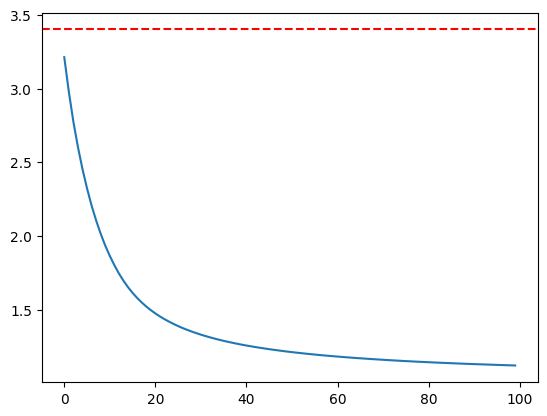

In [55]:
plt.plot(epoch_wise_loss, label='Epoch-wise Loss')
plt.axhline(y=np.log(PROTOTYPES), color='r', linestyle='--', label='ln(#prototypes)')
plt.savefig(f'figs/{MODEL_TAG}_loss.png')

## Get assigments:

In [46]:
final_data = []
for sample in data:

    for v in range(sample.shape[-1]):
        final_data.append(sample[:,:,v])

In [51]:
try:
    assignments = np.load(f'model_weights/assignments_{MODEL_TAG}.npy',allow_pickle=False)

except:
    blocks=100
    size = int(len(final_data)/blocks)

    for i in range(blocks):

        embeddings_ = feature_backbone(np.asarray(final_data)[i*size:(i+1)*size])
        projection_, prototype_ = projection_prototype(embeddings_)

        if i == 0:
            prototype=np.asarray(prototype_)
        else:
            prototype=np.concatenate([prototype,np.asarray(prototype_)])

    prototype = np.asarray(prototype)
    del projection_,embeddings_

    assignments = np.argmax(softmax(prototype),axis=1)
    np.save(f'model_weights/assignments_{MODEL_TAG}',assignments,allow_pickle=False)

## Simple plots

In [52]:
min_samples= 500
max_samples= len(final_data)

colors_c = [plt.colormaps['tab20'](c) for c in np.linspace(0, 1, num=PROTOTYPES)]
test_data_list = np.asarray(final_data)

Cluster: 0 Shape: (2030, 143, 142) Avg: 0.54036576 Std: 0.07425901
Cluster: 1 Shape: (6556, 143, 142) Avg: 0.4645365 Std: 0.057452243
Cluster: 2 Shape: (10420, 143, 142) Avg: 0.5020116 Std: 0.050834436
Cluster: 3 Shape: (4388, 143, 142) Avg: 0.47801635 Std: 0.055837102
Cluster: 4 Shape: (2672, 143, 142) Avg: 0.50888133 Std: 0.046747774
Cluster: 5 Shape: (1080, 143, 142) Avg: 0.4373564 Std: 0.05736348
Cluster: 6 Shape: (3829, 143, 142) Avg: 0.560435 Std: 0.0730424
Cluster: 7 Shape: (1477, 143, 142) Avg: 0.4955626 Std: 0.045368087
Cluster: 9 Shape: (4057, 143, 142) Avg: 0.48305175 Std: 0.062335208
Cluster: 10 Shape: (3827, 143, 142) Avg: 0.45830768 Std: 0.050941974
Cluster: 11 Shape: (2776, 143, 142) Avg: 0.46376604 Std: 0.07289033
Cluster: 12 Shape: (3881, 143, 142) Avg: 0.48916718 Std: 0.04766321
Cluster: 13 Shape: (4317, 143, 142) Avg: 0.49524412 Std: 0.063303515
Cluster: 14 Shape: (11119, 143, 142) Avg: 0.5114324 Std: 0.060214013
Cluster: 15 Shape: (1423, 143, 142) Avg: 0.5185029 Std

AttributeError: 'ProbPlot' object has no attribute 'savefig'

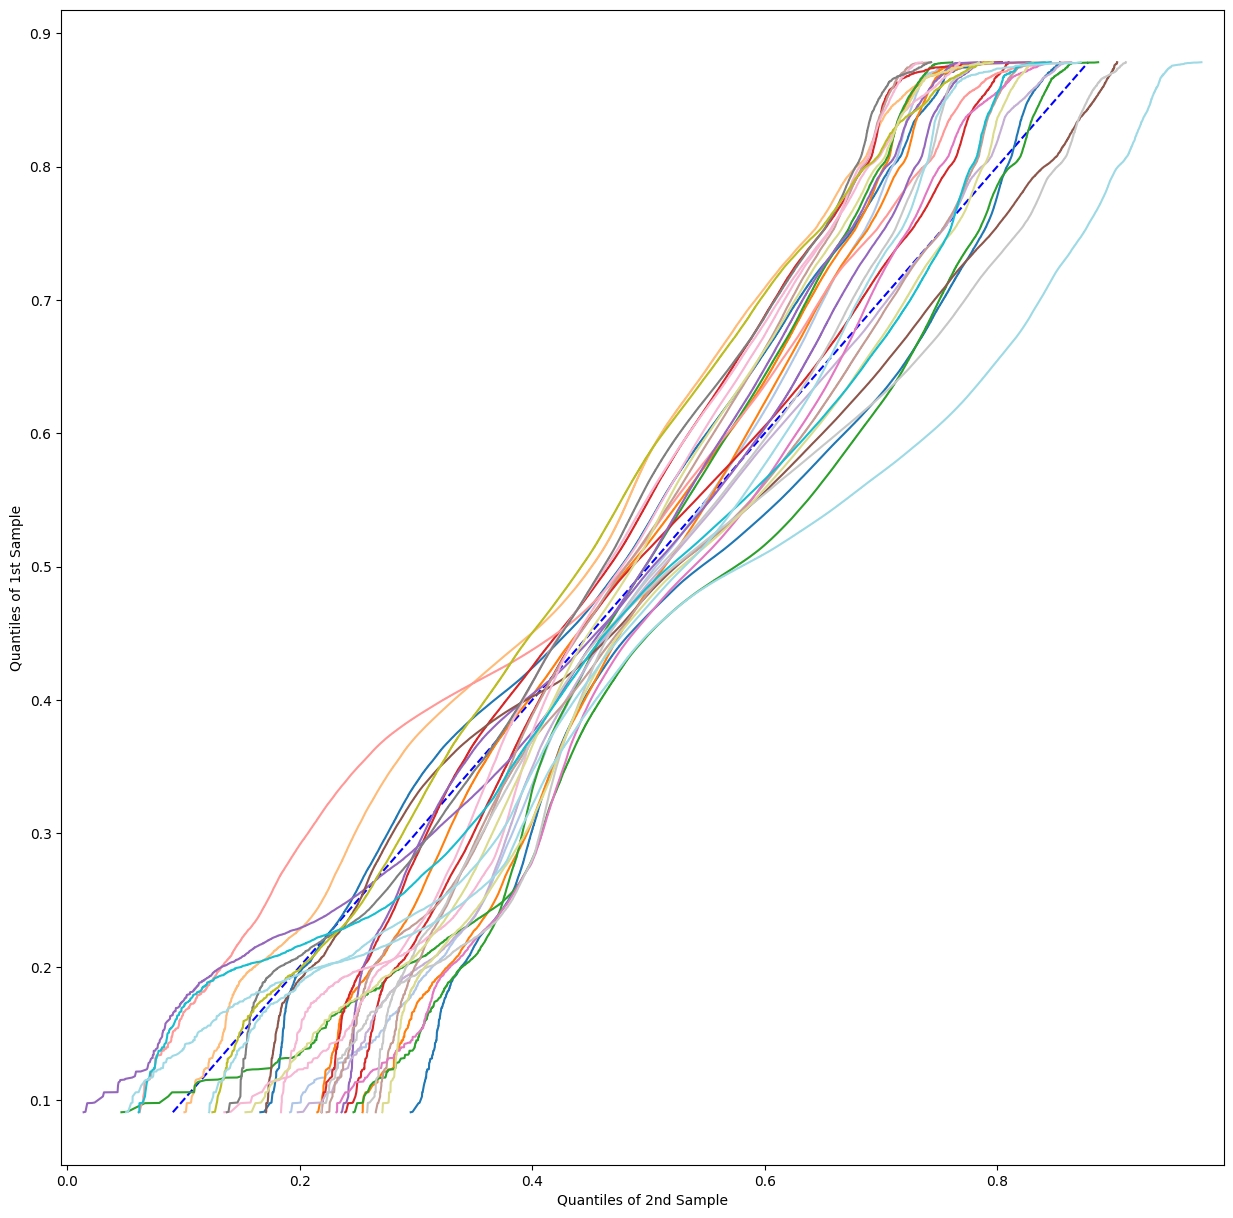

In [53]:
random_samples_ids = np.random.choice(range(test_data_list.shape[0]),size=min_samples) #random samples to QQPLOT
colors_c = [plt.colormaps['tab20'](c) for c in np.linspace(0, 1, num=PROTOTYPES)]

fig, ax = plt.subplots(figsize=(15, 15))

pplot  = sm.ProbPlot(data=test_data_list[random_samples_ids].ravel())
pplot.qqplot(other=pplot,ax=ax, marker='', linestyle='dashed',label= 'self') #45 line

for num, cluster in enumerate(range(PROTOTYPES)): #iterates over each cluster (uses num to get new color)
    
    cur_cluster = test_data_list[assignments==cluster].copy()
    cur_cluster_shape = cur_cluster.shape

    if (cur_cluster_shape[0]>min_samples) and (cur_cluster_shape[0]<max_samples):
        
#         if num in [3,11]:
        #show cluster stats
        print('Cluster:',cluster,'Shape:', cur_cluster_shape,  'Avg:',np.mean(cur_cluster.ravel()),  'Std:', np.std(cur_cluster.ravel()))

        random_samples_ids = np.random.choice(range(cur_cluster_shape[0]),size=min_samples) #random select samples from current cluster

        cur_color = colors_c[num] 
        pplot.qqplot(other=cur_cluster[random_samples_ids].ravel(),ax=ax,marker='', linestyle='solid', color=cur_color,
                        label= f'{cluster}: {cur_cluster_shape[0]}')

#         else:
#             random_samples_ids = np.random.choice(range(cur_cluster_shape[0]),size=min_samples) #random select samples from current cluster

#             pplot.qqplot(other=cur_cluster[random_samples_ids].ravel(),ax=ax,marker='', linestyle='solid', color='lightgrey',
#                           label= f'{cluster}: {cur_cluster_shape[0]}')

fig.savefig(f'figs/{MODEL_TAG}_qqplot.png')

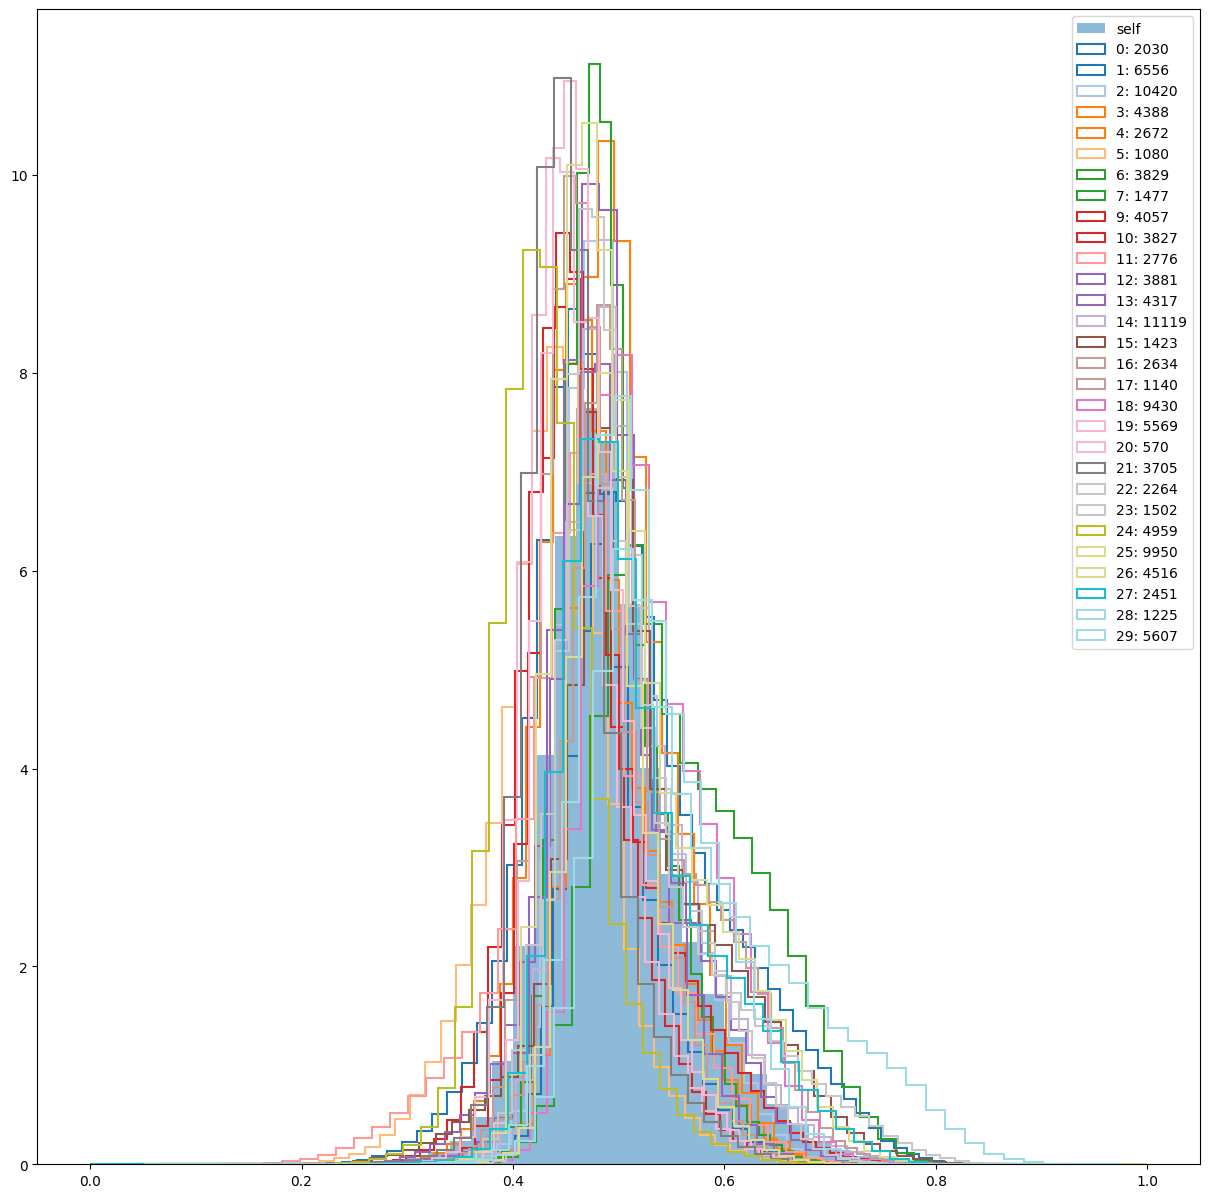

In [56]:
n_bins = 50

fig, ax = plt.subplots(figsize=(15, 15))

plt.hist(test_data_list.ravel(),density=True,bins=n_bins,alpha = 0.5,label= 'self')

for num, cluster in enumerate(range(PROTOTYPES)):
    

    cur_cluster = test_data_list[assignments==cluster].copy()
    cur_cluster_shape = cur_cluster.shape

    if (cur_cluster_shape[0]>min_samples) and (cur_cluster_shape[0]<max_samples):
            
#         if num in []:

            plt.hist(cur_cluster.ravel(),density=True,bins=n_bins,histtype='step',color=colors_c[num],label= f'{cluster}: {cur_cluster_shape[0]}',linewidth=1.5)
        
#         else:
#                  plt.hist(cur_cluster.ravel(),density=True,bins=n_bins,histtype='step',color='lightgrey',label= f'{cluster}: {cur_cluster_shape[0]}',linewidth=0.5)
        

plt.legend()
plt.savefig(f'figs/{MODEL_TAG}_hist.png')

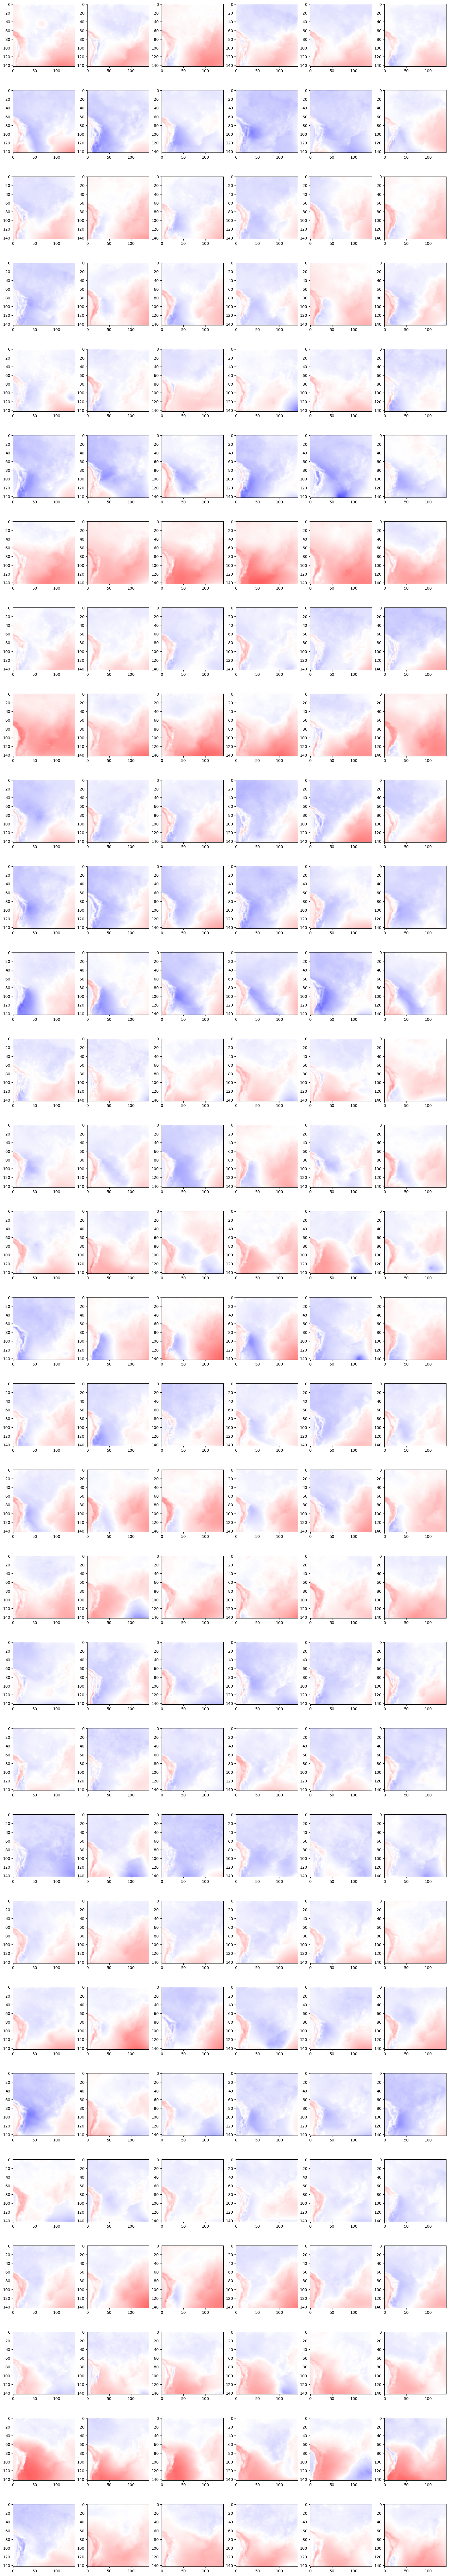

In [57]:
#SAMPLES
num_samples =  6

fig, ax = plt.subplots(PROTOTYPES,num_samples,figsize=(20,4*PROTOTYPES))

for cluster in range(PROTOTYPES):
        
    cluster_indexes = np.where(assignments==cluster)[0]
    samples_indexes = np.random.choice(cluster_indexes,num_samples)

    fig.subplots_adjust(wspace=0.2, hspace=0.01)

    for cur_sample in range(num_samples):
        ax[cluster,cur_sample].imshow(final_data[samples_indexes[cur_sample]],cmap='bwr',vmin=0, vmax=1)

fig.savefig(f"figs/{MODEL_TAG}_samples.png")

In [ ]:
# num_samples =  6
# for cluster in range(PROTOTYPES):
        
#     cluster_indexes = np.where(assignments==cluster)[0]
#     samples_indexes = np.random.choice(cluster_indexes,num_samples)

#     fig, ax = plt.subplots(1,num_samples,figsize=(20,3))
#     fig.suptitle(f"Random samples from cluster: {cluster}", fontsize=16)

#     fig.subplots_adjust(wspace=0.2, hspace=0.01)

#     for cur_sample in range(num_samples):

#         ax[cur_sample].imshow(final_data[samples_indexes[cur_sample]],cmap='bwr',vmin=0, vmax=1)

#     plt.show()